# CNN Cancer Detection Kaggle Mini-Project #

__Author__ : Jayjit Pradhan

__Project Description__ : This project is done as part of Introduction to Deep Learning course Week 3 assignment.

__Project Goal__:

Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates). PCam is highly interesting for both its size, simplicity to get started on, and approachability. 

By Using CNN model I will try to identify images with Tumor or no-tumor classes.

### Import Python Packages

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

## Data Load

Data have been downloaded from Histopathologic Cancer Detection Kaggle website (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) to local and placed in histopathologic-cancer-detection directory.

In [2]:
os.listdir("./histopathologic-cancer-detection/")

['train_labels.csv', '.DS_Store', 'test', 'train', 'sample_submission.csv']

In [3]:
# Define paths
TRAIN_PATH = './histopathologic-cancer-detection/train/'
TEST_PATH = './histopathologic-cancer-detection/test/'
LABELS_PATH = './histopathologic-cancer-detection/train_labels.csv'

### Basic Information

In [4]:
print(f"Number of images in train folder: {len(os.listdir(TRAIN_PATH))}")
print(f"\nNumber of images in test folder: {len(os.listdir(TEST_PATH))}")

labels_df = pd.read_csv(LABELS_PATH)
print(f"\ntrain_labels dataset contains {len(labels_df)} labeled images")

print("\ntraining_label dataset info:")
labels_df.info()

Number of images in train folder: 220025

Number of images in test folder: 57458

train_labels dataset contains 220025 labeled images

training_label dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


__Observations__:
- Training folder contains 220025 images whereas Test folder contains 57458 images.
- Label dataset contains 220025 labeled images.

### Sample Images

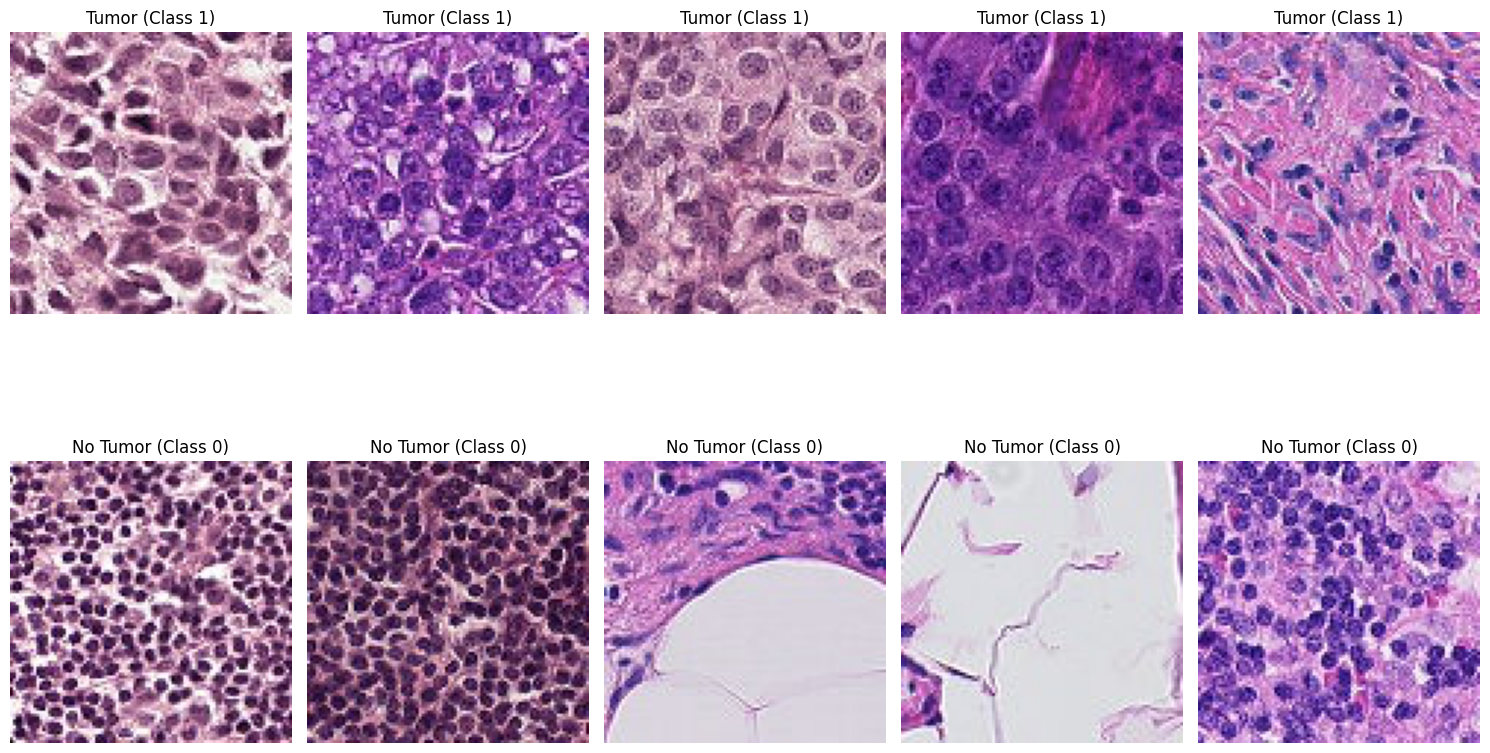

In [5]:
# Load and display sample images
plt.figure(figsize=(15, 10))

# Get sample images from each class
tumor_samples = labels_df[labels_df['label'] == 1].sample(5)['id'].tolist()
non_tumor_samples = labels_df[labels_df['label'] == 0].sample(5)['id'].tolist()

# Plot tumor samples
for i, img_id in enumerate(tumor_samples):
    img_path = os.path.join(TRAIN_PATH, f"{img_id}.tif")
    img = plt.imread(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Tumor (Class 1)")
    plt.axis('off')

# Plot non-tumor samples
for i, img_id in enumerate(non_tumor_samples):
    img_path = os.path.join(TRAIN_PATH, f"{img_id}.tif")
    img = plt.imread(img_path)
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title(f"No Tumor (Class 0)")
    plt.axis('off')

plt.tight_layout()
plt.show()

## EDA

### Analyze Image Properties

In [6]:
img_path = os.path.join(TRAIN_PATH, f"{tumor_samples[0]}.tif")
img = plt.imread(img_path)
img_shape= img.shape
print(f"Image Properties:")
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")
print(f"Pixel value range: {img.min()} to {img.max()}")

Image Properties:
Image shape: (96, 96, 3)
Image data type: uint8
Pixel value range: 2 to 255


### Image Label distribution


Class Distribution:
Class 0 (No tumor): 130908 images (59.50%)
Class 1 (Tumor): 89117 images (40.50%)


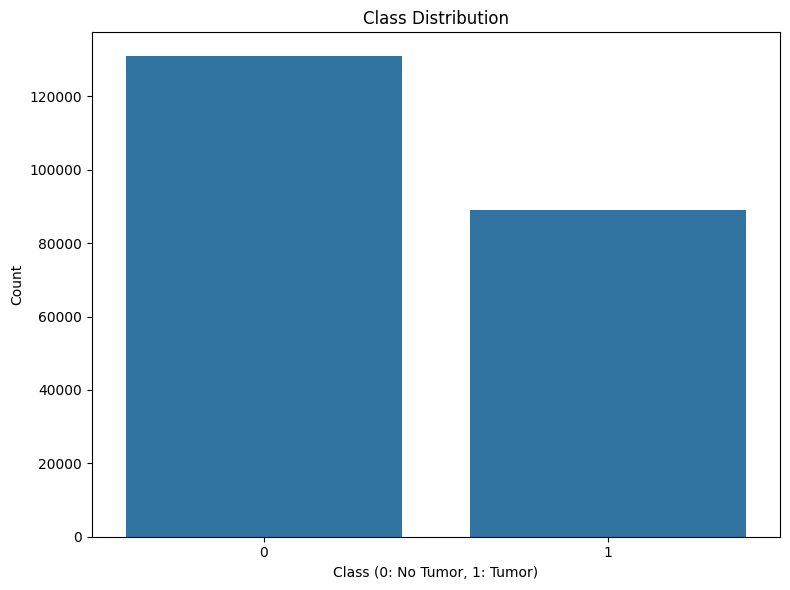

In [7]:
# Check class distribution
class_counts = labels_df['label'].value_counts()
class_percentages = labels_df['label'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(f"Class 0 (No tumor): {class_counts[0]} images ({class_percentages[0]:.2f}%)")
print(f"Class 1 (Tumor): {class_counts[1]} images ({class_percentages[1]:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=labels_df)
plt.title('Class Distribution')
plt.xlabel('Class (0: No Tumor, 1: Tumor)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

__Observations__:
- Within the 220025 images in label dataset, 130908 images (59.50%) are of No Tumor (class 0) and rest 89117 images (40.50%) as Tumor (class 1).

### Pixel Intensity Distribution

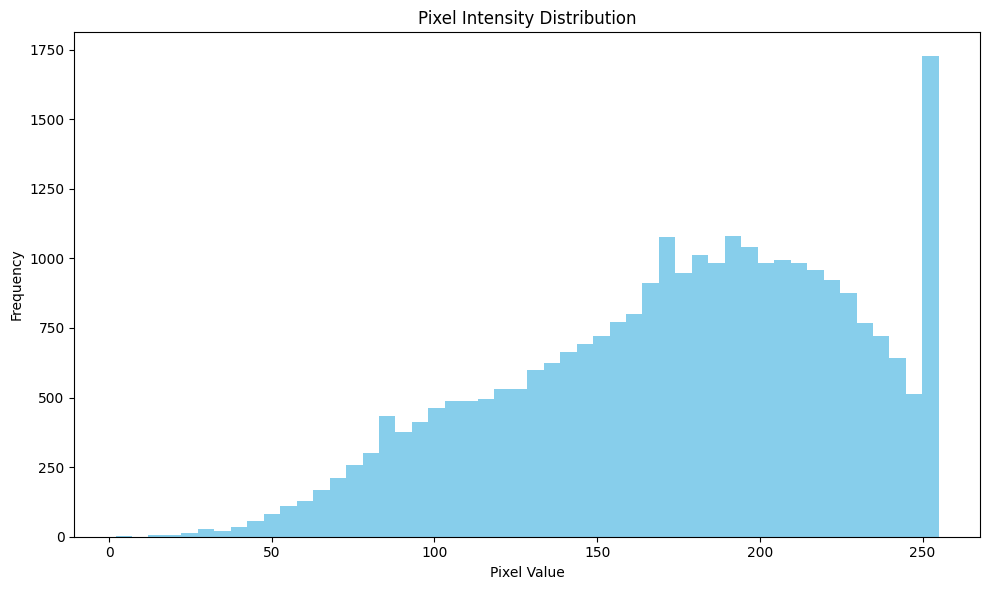

In [8]:
# Pixel intensity distribution
plt.figure(figsize=(10, 6))
plt.hist(img.ravel(), bins=50, color='skyblue')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Pixel Distribution in RGB Channels

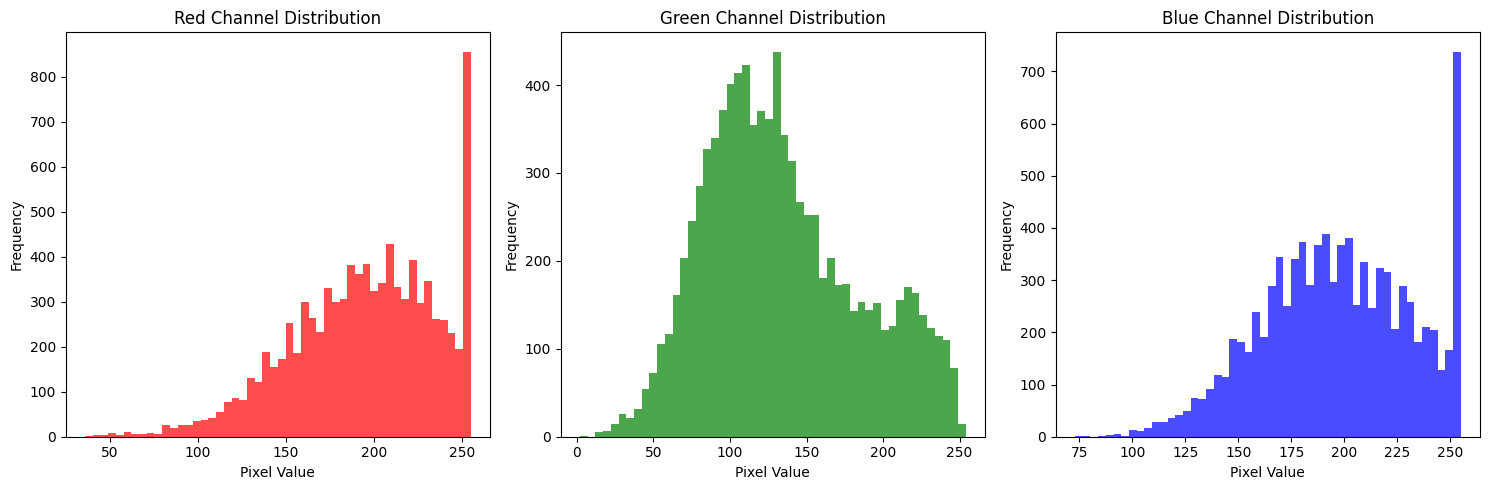

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(img[:, :, 0].flatten(), bins=50, color='red', alpha=0.7)
plt.title('Red Channel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(img[:, :, 1].flatten(), bins=50, color='green', alpha=0.7)
plt.title('Green Channel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(img[:, :, 2].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Blue Channel Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Pixel Correlation Analysis between RGB Channels

Correlation between Red and Green channels (first image): 0.8777
Correlation between Red and Blue channels (first image): 0.9146
Correlation between Green and Blue channels (first image): 0.9223


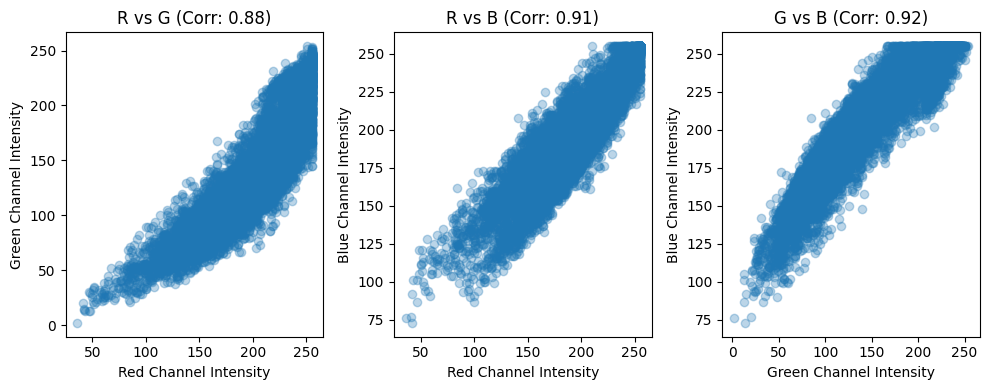

In [10]:
# correlation
red_channel = img[:, :, 0].flatten()
green_channel = img[:, :, 1].flatten()
blue_channel = img[:, :, 2].flatten()

correlation_rg = np.corrcoef(red_channel, green_channel)[0, 1]
correlation_rb = np.corrcoef(red_channel, blue_channel)[0, 1]
correlation_gb = np.corrcoef(green_channel, blue_channel)[0, 1]

print(f"Correlation between Red and Green channels (first image): {correlation_rg:.4f}")
print(f"Correlation between Red and Blue channels (first image): {correlation_rb:.4f}")
print(f"Correlation between Green and Blue channels (first image): {correlation_gb:.4f}")

# Visualize channel correlations for the first image
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.scatter(red_channel, green_channel, alpha=0.3)
plt.title(f'R vs G (Corr: {correlation_rg:.2f})')
plt.xlabel('Red Channel Intensity')
plt.ylabel('Green Channel Intensity')

plt.subplot(1, 3, 2)
plt.scatter(red_channel, blue_channel, alpha=0.3)
plt.title(f'R vs B (Corr: {correlation_rb:.2f})')
plt.xlabel('Red Channel Intensity')
plt.ylabel('Blue Channel Intensity')

plt.subplot(1, 3, 3)
plt.scatter(green_channel, blue_channel, alpha=0.3)
plt.title(f'G vs B (Corr: {correlation_gb:.2f})')
plt.xlabel('Green Channel Intensity')
plt.ylabel('Blue Channel Intensity')

plt.tight_layout()
plt.show()

### Pixel Correlation Matrix

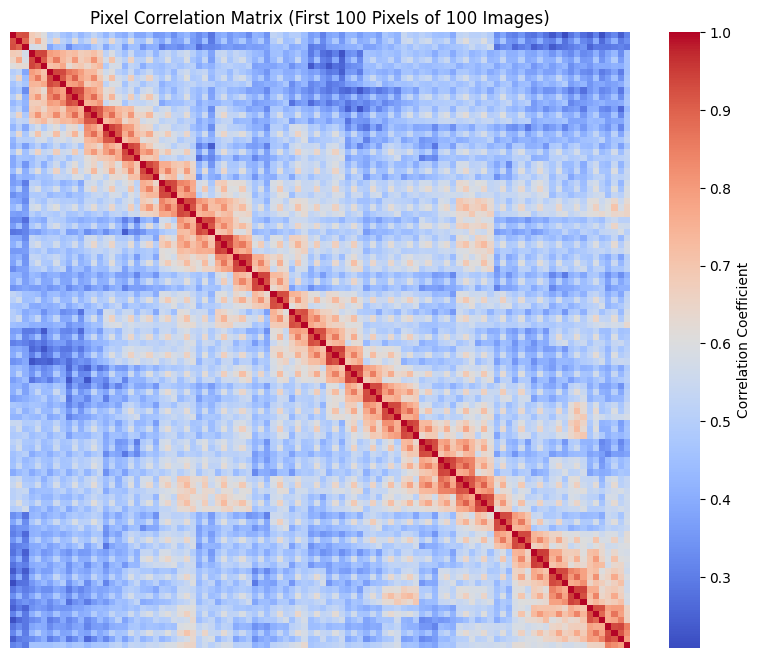

In [11]:
num_samples_corr=100
sample_paths = [os.path.join(TRAIN_PATH, f"{img_id}.tif") for img_id in 
                labels_df.sample(min(num_samples_corr, len(labels_df)))['id']]
sample_images = [plt.imread(path) for path in sample_paths]
subset_images = np.array(sample_images).reshape(num_samples_corr, -1) / 255.0

correlation_matrix = np.corrcoef(subset_images, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[:100, :100], cmap='coolwarm',
            xticklabels=[], yticklabels=[], cbar_kws={'label': 'Correlation Coefficient'})
plt.title(f'Pixel Correlation Matrix (First 100 Pixels of {num_samples_corr} Images)')
plt.show()

In [12]:
# Calculate mean and std for normalization
sample_paths = [os.path.join(TRAIN_PATH, f"{img_id}.tif") for img_id in 
                labels_df.sample(min(1000, len(labels_df)))['id']]
sample_images = [plt.imread(path) for path in sample_paths]

# Convert to numpy array and calculate stats
sample_array = np.array(sample_images)
mean_val = np.mean(sample_array)
std_val = np.std(sample_array)

print(f"\nImage Statistics (from sample):")
print(f"Mean pixel value: {mean_val:.4f}")
print(f"Standard deviation: {std_val:.4f}")


Image Statistics (from sample):
Mean pixel value: 167.3242
Standard deviation: 65.5824


### Center Region of Images

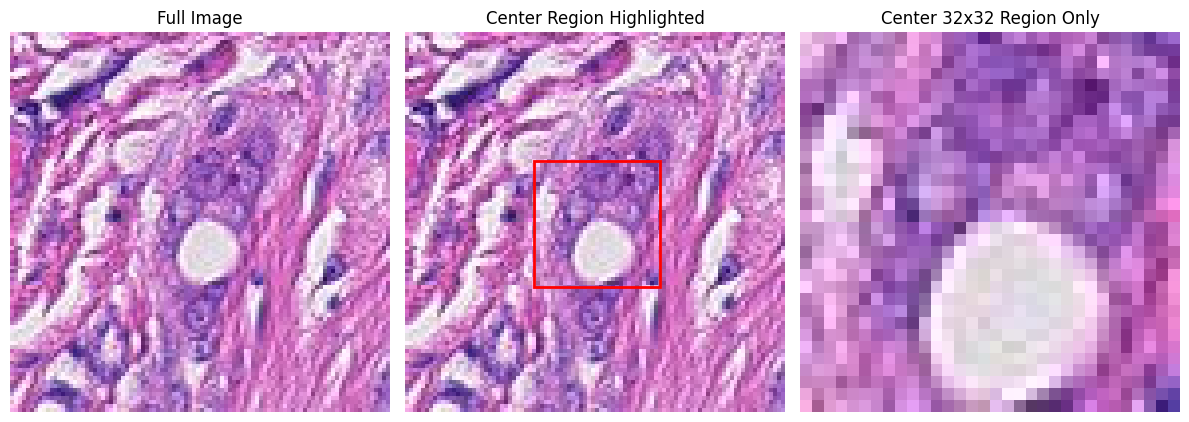

In [13]:
# Show the center 32x32 region (which determines the label)
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Full Image")
plt.axis('off')

# Draw a box around the center region
h, w = img.shape[:2]
center_y, center_x = h // 2, w // 2
box_img = img.copy()

# Create a new figure for the marked image
plt.subplot(1, 3, 2)
plt.imshow(box_img)
rect = plt.Rectangle((center_x-16, center_y-16), 32, 32, edgecolor='red', linewidth=2, fill=False)
plt.gca().add_patch(rect)
plt.title("Center Region Highlighted")
plt.axis('off')

# Extract and display just the center region
center_region = img[center_y-16:center_y+16, center_x-16:center_x+16]
plt.subplot(1, 3, 3)
plt.imshow(center_region)
plt.title("Center 32x32 Region Only")
plt.axis('off')

plt.tight_layout()
plt.show()

### Data Pre-Preprocessing

#### Training Validation Split

In [6]:
# Split data into training and validation sets
train_df, val_df = train_test_split(
    labels_df, 
    test_size=0.25, 
    stratify=labels_df['label'],
    random_state=42
)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

Training set: 165018 images
Validation set: 55007 images


__Observations__:
- In order for initial model creation, training label data have been split in Training and validation set (25%).
- Training set contains 165018 images and Validatin set contains 55007 images.

#### Data Augmentation for Train and Validation set

Data augmentation techniques involve creating new data points from existing ones to increase the size and diversity of a dataset, which can improve model performance and generalization. These techniques are particularly useful when a dataset is limited or not diverse enough to train a robust machine learning model. 

In [7]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation set
val_datagen = ImageDataGenerator(rescale=1./255)

#### Setup Data Generators for Train and Validation set

In [8]:
# Create a customized flow from dataframe function to handle .tif files
def flow_from_dataframe_custom(dataframe, directory, x_col, y_col, datagen, **kwargs):
    # Add .tif extension to the image IDs
    dataframe = dataframe.copy()
    dataframe[x_col] = dataframe[x_col].astype(str) + '.tif'
    
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        **kwargs
    )

In [9]:
# Setup generators
train_generator = flow_from_dataframe_custom(
    dataframe=train_df,
    directory=TRAIN_PATH,
    x_col='id',
    y_col='label',
    datagen=train_datagen,
    target_size=(96, 96),
    batch_size=32,
    class_mode='raw',
    validate_filenames=True,
    shuffle=True,
    seed=42
)

val_generator = flow_from_dataframe_custom(
    dataframe=val_df,
    directory=TRAIN_PATH,
    x_col='id',
    y_col='label',
    datagen=val_datagen,
    target_size=(96, 96),
    batch_size=32,
    class_mode='raw',
    validate_filenames=True,
    shuffle=False
)

Found 165018 validated image filenames.
Found 55007 validated image filenames.


#### Visualize Augmented Images

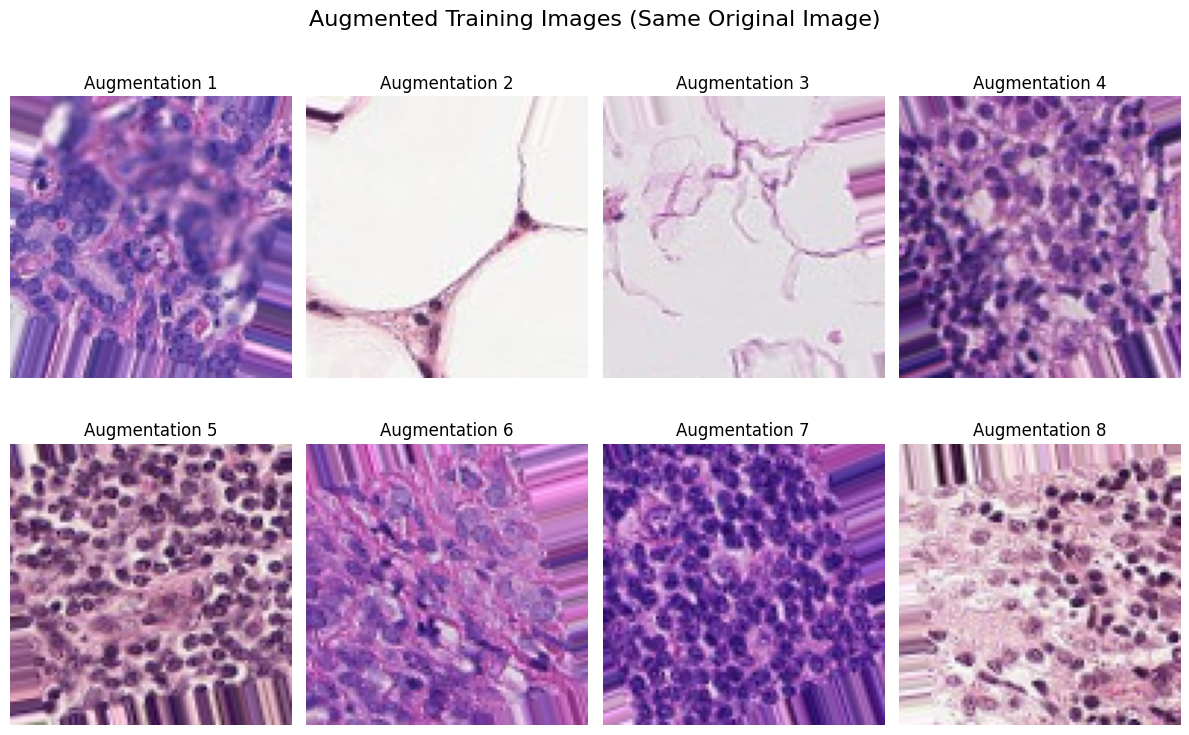

In [18]:
plt.figure(figsize=(12, 8))
plt.suptitle('Augmented Training Images (Same Original Image)', fontsize=16)

# Get a batch from the training generator
x_batch, y_batch = next(train_generator)

# Display a few augmented versions of the same image
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[0])  # Always show the first image in the batch to see different augmentations
    plt.title(f"Augmentation {i+1}")
    plt.axis('off')
    
    # Generate a new batch to get a different augmentation
    x_batch, y_batch = next(train_generator)

plt.tight_layout()
plt.show()

## CNN Model Build

In [10]:
def randomSeedClear():
    # Fixing the seed for random number generators
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

### Baseline CNN Model

In [11]:
randomSeedClear()

baseline_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96,96,3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Baseline Model Summary:")
baseline_model.summary()

Baseline Model Summary:


2025-05-16 12:58:18.609224: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-16 12:58:18.609250: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-16 12:58:18.609255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-16 12:58:18.609276: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-16 12:58:18.609283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

__Observations:__
- Baseline CNN model created with 3 convolution layers having 32, 64 & 128 layers respectively.
- 'relu' activation function have been used for all 3 convolution layers with padding as 'same'.
- 1 hidden dense layer have been used with 128 neurons & activation function as 'relu' and output layer 1 neuron activation 'sigmoid' respectively.
- CNN model is compiled with 'Adam' optimizer with learning_rate of 0.001 with loss function as 'binary_crossentropy' and 'accuracy' as evaluation matrix.

### Training Baseline CNN Model

In [12]:
# early_stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = baseline_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)


Epoch 1/10


2025-05-16 12:58:23.206228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5157/5157 ━━━━━━━━━━━━━━━━━━━━ 187s 36ms/step - accuracy: 0.7588 - loss: 0.5184 - val_accuracy: 0.7707 - val_loss: 0.5356
Epoch 2/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 144s 28ms/step - accuracy: 0.7664 - loss: 0.5738 - val_accuracy: 0.8256 - val_loss: 0.3983
Epoch 3/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 141s 27ms/step - accuracy: 0.7454 - loss: 0.8485 - val_accuracy: 0.7365 - val_loss: 3.2170
Epoch 4/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 141s 27ms/step - accuracy: 0.6624 - loss: 3.9068 - val_accuracy: 0.6873 - val_loss: 8.6563
Epoch 5/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 141s 27ms/step - accuracy: 0.6420 - loss: 10.2562 - val_accuracy: 0.6255 - val_loss: 5.5263
Epoch 6/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 139s 27ms/step - accuracy: 0.6148 - loss: 13.6990 - val_accuracy: 0.7909 - val_loss: 3.2086
Epoch 7/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 141s 27ms/step - accuracy: 0.6790 - loss: 19.7956 - val_accuracy: 0.7996 - val_loss: 13.2106
Epoch 7: early stopping
Restoring model weights from the end of the best epo

__Observations:__
- Baseline CNN model is trained with training set with training accuracy as 0.7664 and validation accuracy of 0.8256.
- Respective training loss is 0.5738 and validation loss is 0.3983.

### Visualizing Training History

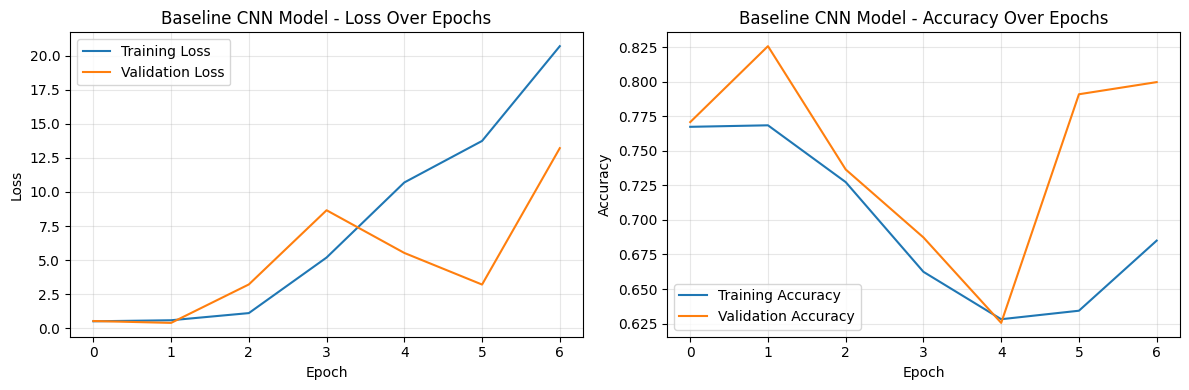


Best epoch: 2
Best validation loss: 0.3983
Corresponding validation accuracy: 0.8256


In [13]:
model_name="Baseline CNN Model"

# Get metrics
metrics = history.history

# Plot training curves
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best epoch
best_epoch = np.argmin(metrics['val_loss'])
print(f"\nBest epoch: {best_epoch+1}")
print(f"Best validation loss: {metrics['val_loss'][best_epoch]:.4f}")
print(f"Corresponding validation accuracy: {metrics['val_accuracy'][best_epoch]:.4f}")

### Baseline CNN Model Prediction on Validation Set

In [14]:
# Get predictions
y_pred_prob = baseline_model.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = val_df['label'].values.astype(int)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step


### Baseline CNN Model Prediction Metrics

In [15]:
# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Baseline CNN Model - Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Baseline CNN Model - Evaluation Metrics:
Accuracy: 0.8256
Precision: 0.8479
Recall: 0.6940
F1 Score: 0.7633


__Observations:__
- Baseline model provides accuracy of 0.8256 in validation set with a F1 score of 0.7633 suggesting good model performance.

### Baseline CNN Model Confusion Metrix

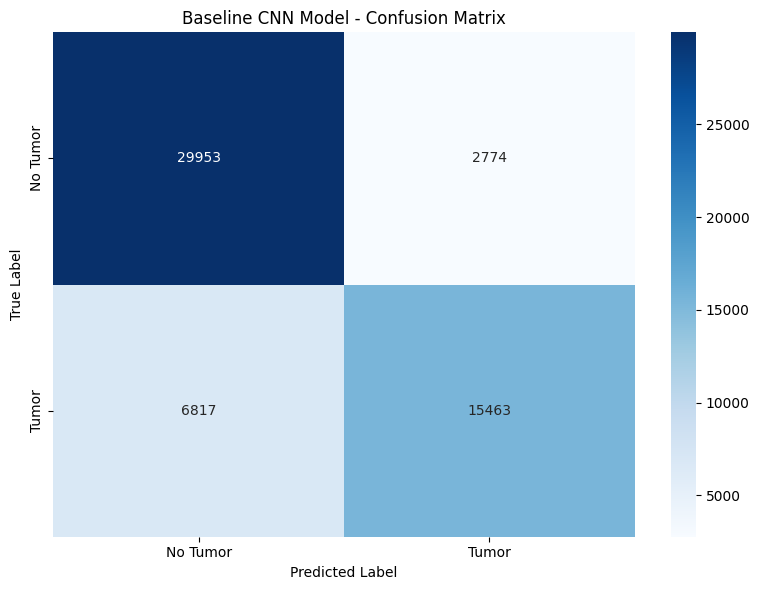

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline CNN Model - Confusion Matrix')
plt.tight_layout()
plt.show()

### Baseline CNN Model AUC-ROC Curve

### Baseline CNN Model Visualizing Predictions

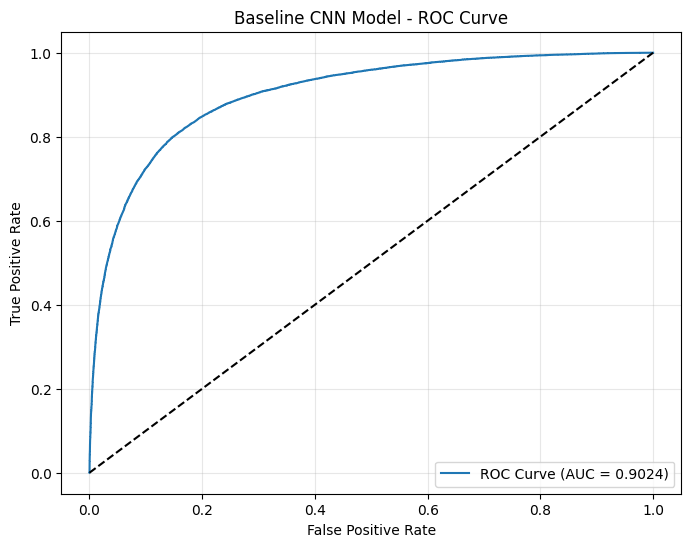

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline CNN Model - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


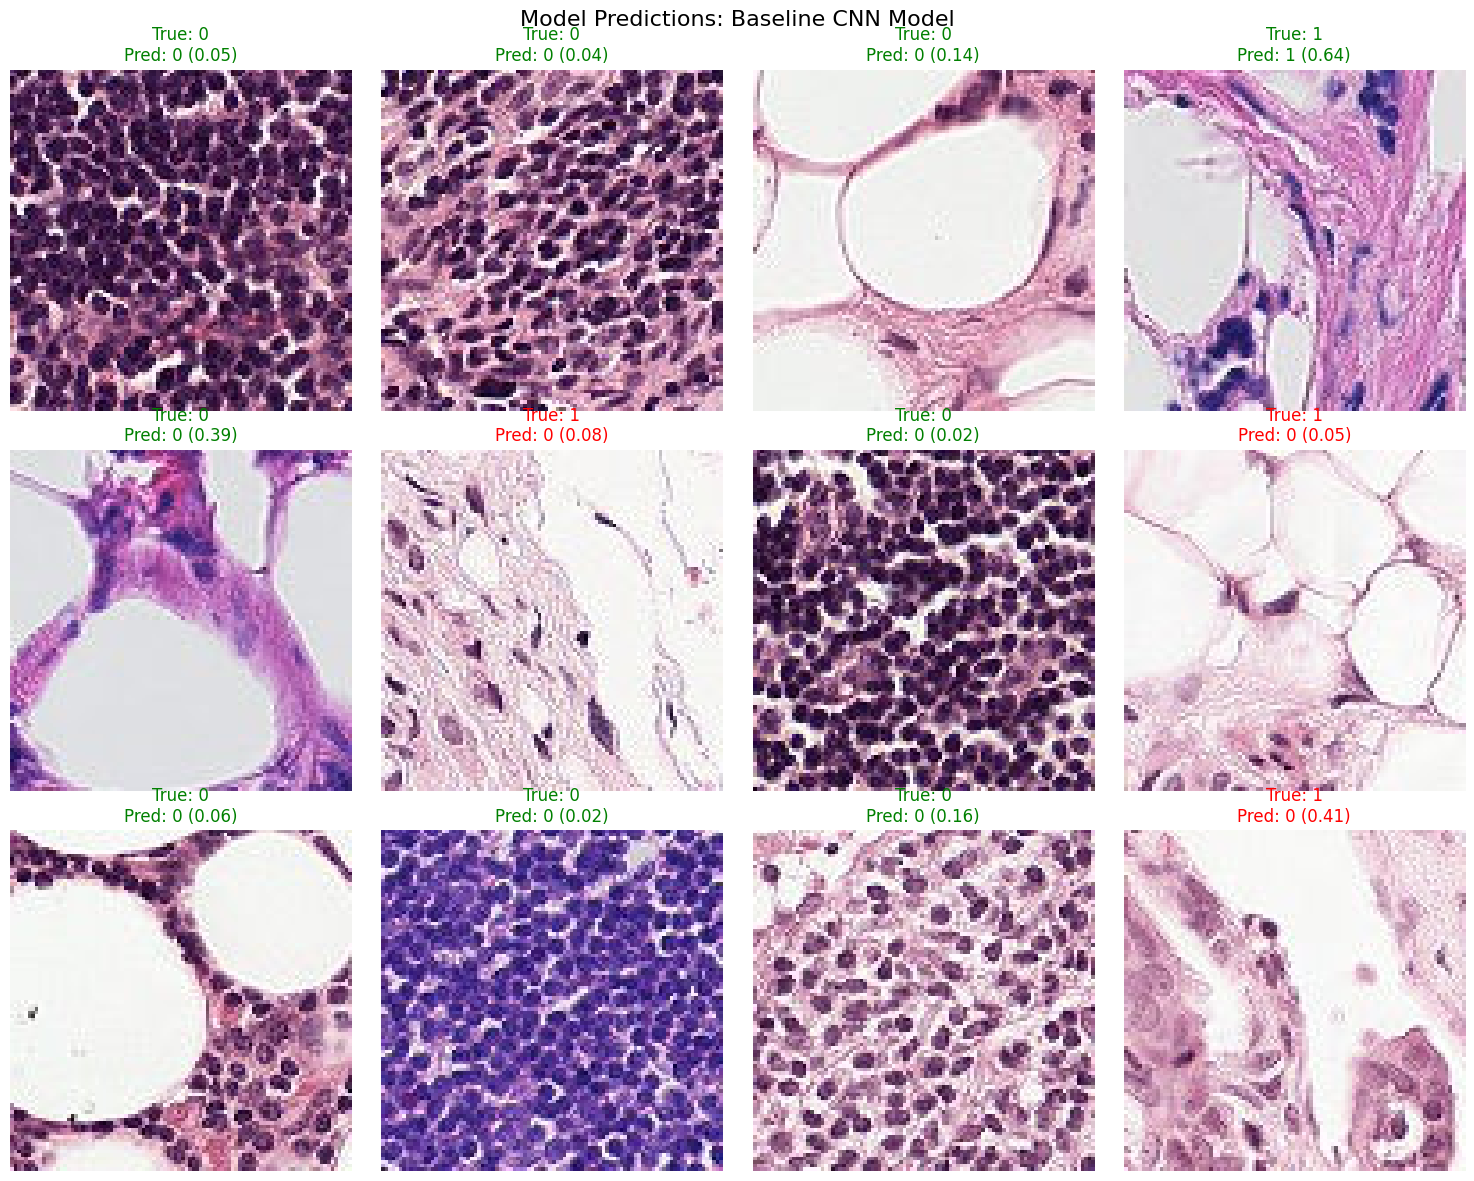

In [18]:
model_name="Baseline CNN Model"

# Get a batch from validation generator
x_batch, y_batch = next(val_generator)

# Get predictions
y_pred_prob = baseline_model.predict(x_batch)
y_pred = (y_pred_prob > 0.5).astype(int)

# Plot predictions
plt.figure(figsize=(15, 12))
plt.suptitle(f'Model Predictions: {model_name}', fontsize=16)

for i in range(min(12, len(x_batch))):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_batch[i])
    
    # Determine if prediction is correct
    is_correct = y_pred[i][0] == y_batch[i]
    title_color = 'green' if is_correct else 'red'
    
    # Create title with prediction information
    title = f"True: {int(y_batch[i])}\nPred: {int(y_pred[i][0])} ({y_pred_prob[i][0]:.2f})"
    plt.title(title, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Hyper-parameter Tuning on Baseline CNN Model

In [28]:
randomSeedClear()

# Define hyperparameter combinations to try
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
dropout_rates = [0.25, 0.5]
input_shape = (96,96,3)

# Store results
results = []
best_val_loss = float('inf')
best_params = {}

# Original batch sizes
original_train_batch = train_generator.batch_size
original_val_batch = val_generator.batch_size

for lr in learning_rates:
    for batch_size in batch_sizes:
        for dropout in dropout_rates:
            print(f"\nTesting: LR={lr}, Batch={batch_size}, Dropout={dropout}")
            
            # Update generators with new batch size
            train_generator.batch_size = batch_size
            val_generator.batch_size = batch_size

            model = Sequential([
                    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96,96,3)),
                    MaxPooling2D((2, 2)),
                    
                    Conv2D(64, (3, 3), activation='relu', padding='same'),
                    MaxPooling2D((2, 2)),
                    
                    Conv2D(128, (3, 3), activation='relu', padding='same'),
                    MaxPooling2D((2, 2)),
                    
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(dropout),
                    Dense(1, activation='sigmoid')
                ])
                
            model.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Train with early stopping
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
            
            history = model.fit(
                train_generator,
                epochs=10,            
                validation_data=val_generator,
                callbacks=[early_stopping],
                verbose=1
            )
            
            # Get the best validation metrics
            best_epoch = np.argmin(history.history['val_loss'])
            val_accuracy = history.history['val_accuracy'][best_epoch]
            val_loss = history.history['val_loss'][best_epoch]
            
            # Store results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'dropout': dropout,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            })
            
            print(f"Results: Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.4f}")
            
            # Track best parameters
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'dropout': dropout
                }

# Reset to original batch sizes
train_generator.batch_size = original_train_batch
val_generator.batch_size = original_val_batch


print("\nBest Hyperparameter Combination:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Batch Size: {best_params['batch_size']}")
print(f"Dropout Rate: {best_params['dropout']}")
print(f"Validation Loss: {best_val_loss:.4f}")


Testing: LR=0.001, Batch=32, Dropout=0.25
Epoch 1/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 178s 34ms/step - accuracy: 0.7269 - loss: 0.5733 - val_accuracy: 0.7550 - val_loss: 0.4952
Epoch 2/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 177s 34ms/step - accuracy: 0.7340 - loss: 0.6873 - val_accuracy: 0.7348 - val_loss: 0.6363
Epoch 3/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 178s 35ms/step - accuracy: 0.6966 - loss: 1.2315 - val_accuracy: 0.7304 - val_loss: 0.6767
Epoch 4/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 177s 34ms/step - accuracy: 0.7361 - loss: 1.3801 - val_accuracy: 0.7999 - val_loss: 2.3628
Results: Val Loss=0.4952, Val Accuracy=0.7550

Testing: LR=0.001, Batch=32, Dropout=0.5
Epoch 1/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 177s 34ms/step - accuracy: 0.5936 - loss: 1.1727 - val_accuracy: 0.4050 - val_loss: 0.9960
Epoch 2/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 178s 35ms/step - accuracy: 0.5338 - loss: 0.8156 - val_accuracy: 0.5937 - val_loss: 0.6740
Epoch 3/10
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 178s 35ms/step - accuracy: 0.

### Visualizing Training Results

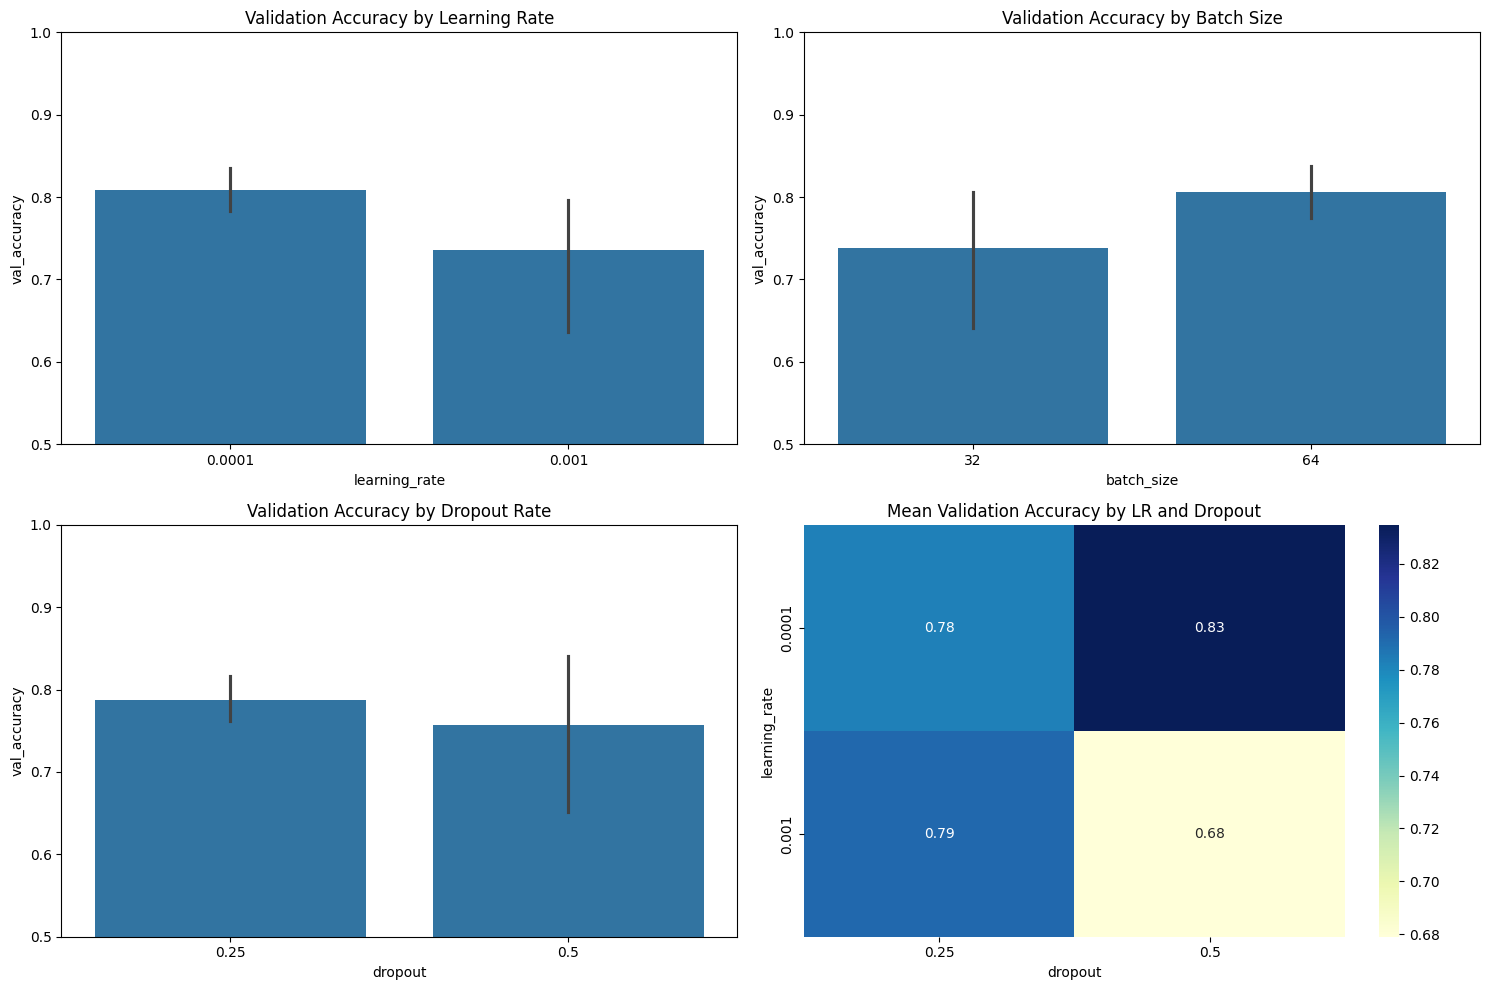

In [29]:
# Convert to DataFrame and visualize results
results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(15, 10))

# Learning rate comparison
plt.subplot(2, 2, 1)
sns.barplot(x='learning_rate', y='val_accuracy', data=results_df)
plt.title('Validation Accuracy by Learning Rate')
plt.ylim(0.5, 1.0)

# Batch size comparison
plt.subplot(2, 2, 2)
sns.barplot(x='batch_size', y='val_accuracy', data=results_df)
plt.title('Validation Accuracy by Batch Size')
plt.ylim(0.5, 1.0)

# Dropout comparison
plt.subplot(2, 2, 3)
sns.barplot(x='dropout', y='val_accuracy', data=results_df)
plt.title('Validation Accuracy by Dropout Rate')
plt.ylim(0.5, 1.0)

# Combined parameter heatmap
plt.subplot(2, 2, 4)
pivot_table = results_df.pivot_table(
    index='learning_rate', 
    columns='dropout',
    values='val_accuracy',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Mean Validation Accuracy by LR and Dropout')

plt.tight_layout()
plt.show()

### Hyparparameter Tuned CNN Model

In [19]:
randomSeedClear()

best_params={'learning_rate': 0.0001, 'batch_size': 64, 'dropout': 0.5}
# Set generators to use best batch size
train_generator.batch_size = int(best_params['batch_size'])
val_generator.batch_size = int(best_params['batch_size'])

ht_cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96,96,3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(best_params['dropout']),
        Dense(1, activation='sigmoid')
    ])
    
ht_cnn_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

print("Hyparparameter Tuned CNN Model Summary:")
ht_cnn_model.summary()

Hyparparameter Tuned CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,801 (9.36 MB)

 Trainable params: 2,452,801 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

__Observations__:
- Hyparameter tuned model created with batch_size as 64, learning_Rate 0.0001 & dropout as 0.5.

### Hyparameter Tuned CNN Model Training

In [20]:
# Setup callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'ht_cnn_model_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = ht_cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7590 - auc: 0.8183 - loss: 0.5171 - precision: 0.7372 - recall: 0.6234
Epoch 1: val_loss improved from inf to 0.64553, saving model to ht_cnn_model_best.h5


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - accuracy: 0.7590 - auc: 0.8183 - loss: 0.5171 - precision: 0.7372 - recall: 0.6234 - val_accuracy: 0.6308 - val_auc: 0.7247 - val_loss: 0.6455 - val_precision: 0.5282 - val_recall: 0.8290 - learning_rate: 1.0000e-04
Epoch 2/20
2578/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6927 - auc: 0.7467 - loss: 0.7123 - precision: 0.6246 - recall: 0.5964
Epoch 2: val_loss did not improve from 0.64553
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - accuracy: 0.6927 - auc: 0.7467 - loss: 0.7123 - precision: 0.6247 - recall: 0.5965 - val_accuracy: 0.7145 - val_auc: 0.7968 - val_loss: 0.8203 - val_precision: 0.8105 - val_recall: 0.3851 - learning_rate: 1.0000e-04
Epoch 3/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7512 - auc: 0.8147 - loss: 0.5777 - precision: 0.7049 - recall: 0.6639
Epoch 3: val_loss improved from 0.64553 to 0.62483, saving model to ht_cnn_model_best.h5


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.7512 - auc: 0.8147 - loss: 0.5777 - precision: 0.7049 - recall: 0.6639 - val_accuracy: 0.7364 - val_auc: 0.8321 - val_loss: 0.6248 - val_precision: 0.8286 - val_recall: 0.4404 - learning_rate: 1.0000e-04
Epoch 4/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7810 - auc: 0.8450 - loss: 0.4875 - precision: 0.7505 - recall: 0.6896
Epoch 4: val_loss improved from 0.62483 to 0.61412, saving model to ht_cnn_model_best.h5


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.7810 - auc: 0.8450 - loss: 0.4875 - precision: 0.7505 - recall: 0.6896 - val_accuracy: 0.7317 - val_auc: 0.8516 - val_loss: 0.6141 - val_precision: 0.8944 - val_recall: 0.3827 - learning_rate: 1.0000e-04
Epoch 5/20
2578/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7983 - auc: 0.8614 - loss: 0.4559 - precision: 0.7806 - recall: 0.6985
Epoch 5: val_loss improved from 0.61412 to 0.53822, saving model to ht_cnn_model_best.h5


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - accuracy: 0.7983 - auc: 0.8614 - loss: 0.4559 - precision: 0.7806 - recall: 0.6985 - val_accuracy: 0.7527 - val_auc: 0.8398 - val_loss: 0.5382 - val_precision: 0.8228 - val_recall: 0.4963 - learning_rate: 1.0000e-04
Epoch 6/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8065 - auc: 0.8698 - loss: 0.4416 - precision: 0.8024 - recall: 0.6930
Epoch 6: val_loss did not improve from 0.53822
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 140s 54ms/step - accuracy: 0.8065 - auc: 0.8698 - loss: 0.4416 - precision: 0.8024 - recall: 0.6930 - val_accuracy: 0.7638 - val_auc: 0.8531 - val_loss: 0.5499 - val_precision: 0.8712 - val_recall: 0.4892 - learning_rate: 1.0000e-04
Epoch 7/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8138 - auc: 0.8743 - loss: 0.4352 - precision: 0.8149 - recall: 0.6991
Epoch 7: val_loss improved from 0.53822 to 0.41747, saving model to ht_cnn_model_best.h5


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 142s 55ms/step - accuracy: 0.8138 - auc: 0.8743 - loss: 0.4352 - precision: 0.8149 - recall: 0.6991 - val_accuracy: 0.8140 - val_auc: 0.8829 - val_loss: 0.4175 - val_precision: 0.8238 - val_recall: 0.6880 - learning_rate: 1.0000e-04
Epoch 8/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8131 - auc: 0.8767 - loss: 0.4316 - precision: 0.8146 - recall: 0.6992
Epoch 8: val_loss did not improve from 0.41747
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 141s 55ms/step - accuracy: 0.8131 - auc: 0.8767 - loss: 0.4316 - precision: 0.8146 - recall: 0.6992 - val_accuracy: 0.8092 - val_auc: 0.8805 - val_loss: 0.4241 - val_precision: 0.7935 - val_recall: 0.7151 - learning_rate: 1.0000e-04
Epoch 9/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8163 - auc: 0.8785 - loss: 0.4286 - precision: 0.8141 - recall: 0.7060
Epoch 9: val_loss did not improve from 0.41747
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step - accuracy: 0.8163 - auc: 0.8785 - loss: 0.4286 - pr

__Observations__:
- Model training completed with training accuracy of 0.8138 and validation accuracy as 0.8140.
- Corresponding training loss is 0.4352 and validation loss is 0.4175.

### Visualizing Training History

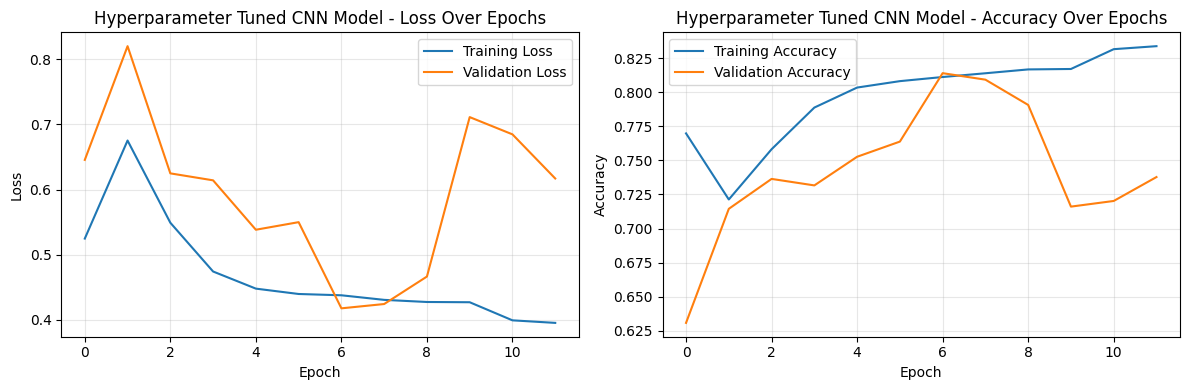


Best epoch: 7
Best validation loss: 0.4175
Corresponding validation accuracy: 0.8140
Corresponding validation precision: 0.8238
Corresponding validation recall: 0.6880
Corresponding validation F1: 0.7498


In [21]:
model_name="Hyperparameter Tuned CNN Model"

# Get metrics
metrics = history.history

# Plot training curves
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best epoch
best_epoch = np.argmin(metrics['val_loss'])
print(f"\nBest epoch: {best_epoch+1}")
print(f"Best validation loss: {metrics['val_loss'][best_epoch]:.4f}")
print(f"Corresponding validation accuracy: {metrics['val_accuracy'][best_epoch]:.4f}")
print(f"Corresponding validation precision: {metrics['val_precision'][best_epoch]:.4f}")
print(f"Corresponding validation recall: {metrics['val_recall'][best_epoch]:.4f}")
f1=(2*metrics['val_precision'][best_epoch]*metrics['val_recall'][best_epoch]/(metrics['val_recall'][best_epoch]+metrics['val_precision'][best_epoch]))
print(f"Corresponding validation F1: {f1:.4f}")

### Hyperparameter Tuned CNN Model Prediction on Validation Set

In [22]:
# Get predictions
y_pred_prob = ht_cnn_model.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = val_df['label'].values.astype(int)

860/860 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


### Hyperparameter Tuned CNN Model Prediction Metrics

In [23]:
# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Hyperparameter Tuned CNN Model - Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Hyperparameter Tuned CNN Model - Evaluation Metrics:
Accuracy: 0.8140
Precision: 0.8238
Recall: 0.6880
F1 Score: 0.7498


__Observations:__
- Hyperparamter Tuned CNN model gives accuracy opf 0.8140 and F1 score as 0.7498.

### Hyperparameter Tuned CNN Model Confusion Metrix

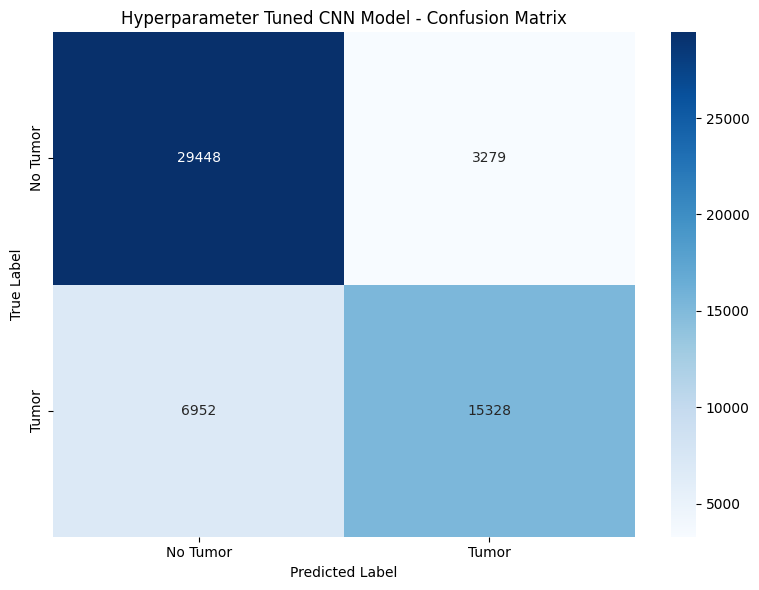

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Hyperparameter Tuned CNN Model - Confusion Matrix')
plt.tight_layout()
plt.show()

### Hyperparameter Tuned CNN Model AUC-ROC Curve

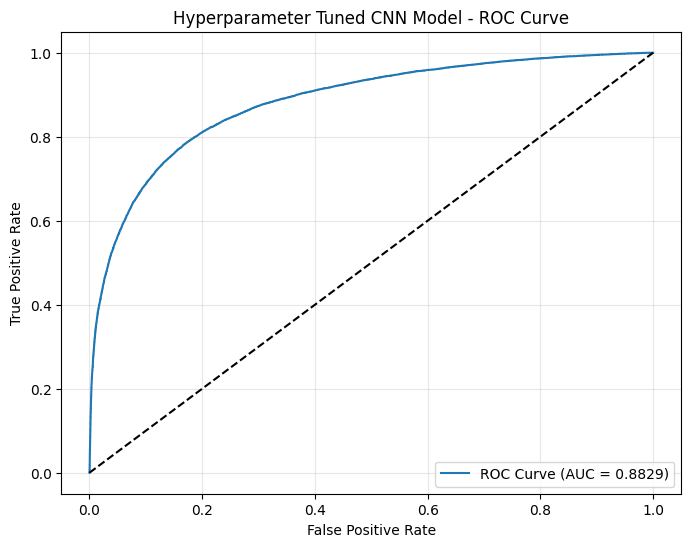

In [25]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hyperparameter Tuned CNN Model - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

### Hyperparameter Tuned CNN Model Visualizing Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


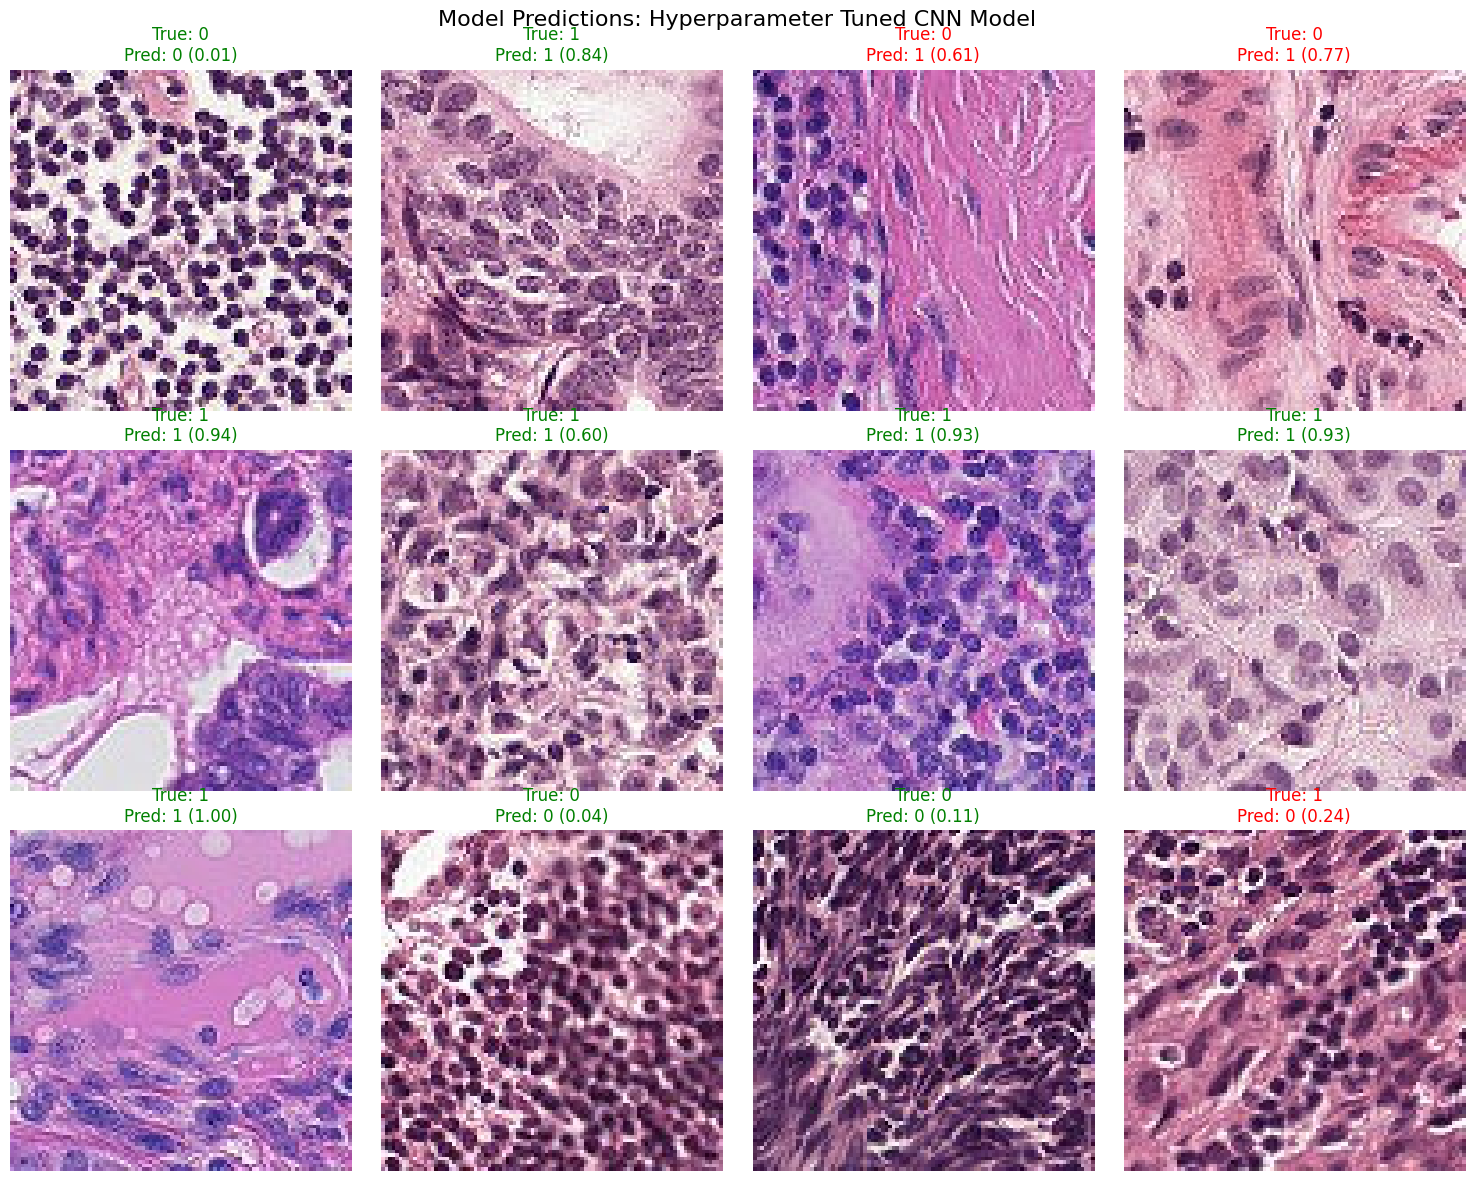

In [26]:
model_name="Hyperparameter Tuned CNN Model"

# Get a batch from validation generator
x_batch, y_batch = next(val_generator)

# Get predictions
y_pred_prob = baseline_model.predict(x_batch)
y_pred = (y_pred_prob > 0.5).astype(int)

# Plot predictions
plt.figure(figsize=(15, 12))
plt.suptitle(f'Model Predictions: {model_name}', fontsize=16)

for i in range(min(12, len(x_batch))):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_batch[i])
    
    # Determine if prediction is correct
    is_correct = y_pred[i][0] == y_batch[i]
    title_color = 'green' if is_correct else 'red'
    
    # Create title with prediction information
    title = f"True: {int(y_batch[i])}\nPred: {int(y_pred[i][0])} ({y_pred_prob[i][0]:.2f})"
    plt.title(title, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Model Solution on Test Data

In [28]:
# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
input_shape=(96,96,3)

# List test files
test_files = os.listdir(TEST_PATH)
test_ids = [file.split('.')[0] for file in test_files if file.endswith('.tif')]

# Create a test dataframe
test_df = pd.DataFrame({'id': test_ids})

def flow_from_dataframe_test(dataframe, directory, x_col, datagen, **kwargs):
        # Add .tif extension to the image IDs
        dataframe = dataframe.copy()
        dataframe[x_col] = dataframe[x_col].astype(str) + '.tif'
        
        return datagen.flow_from_dataframe(
            dataframe=dataframe,
            directory=directory,
            x_col=x_col,
            class_mode=None,  # No labels for test set
            **kwargs
        )
    
test_generator = flow_from_dataframe_test(
    dataframe=test_df,
    directory=TEST_PATH,
    x_col='id',
    datagen=test_datagen,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=64,
    shuffle=False,
    color_mode='rgb' if len(input_shape) > 2 and input_shape[2] == 3 else 'grayscale'
)

Found 57458 validated image filenames.


In [29]:
# Generate predictions
test_predictions = ht_cnn_model.predict(test_generator)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Create submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions_binary.flatten()
})

submission_df.to_csv('submission_v0.csv', index=False)
print(f"Created submission file with {len(submission_df)} predictions.")

898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step
Created submission file with 57458 predictions.
